# Chi-Square Cut and Averaging

## Part 1: Chi-Square Cut

This iPython notebook will help you ascertain the best chi-square cut for a certain supernova's ATLAS light curve. After running a cell, the descriptions located above that cell will help you interpret the plots and make decisions about the supernova.

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

In order for this notebook to work correctly, the ATLAS light curve must already be downloaded and saved. It must also only include measurements for a single filter.

In [1]:
# import modules, set preliminary variables, etc.

import sys, re
import numpy as np
from copy import deepcopy
import sigmacut


# storing, accessing, and manipulating the light curve
import pandas as pd
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# getting discovery date from TNS
import requests, json
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.size'] = 12

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

# dictionary for storing important information about the light curve
global lc_info
lc_info = {}

### 1: Load the ATLAS light curve, account for template changes, etc.

Before analysis on the chi-squares of the light curve can be done, we correct for any potential flux in the template. We do this by calculating the median of any baseline flux with a chi-square less than or equal to 5 and then subtracting that median from the entire light curve. 

In [2]:
# Enter the target SN name:
tnsname = '2019vxm'

# Enter the SN light curve file name:
filename = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt'

# Enter the filter for this light curve (must be 'o' or 'c'):
filter = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using api_key):
discdate = 58818.04
api_key = None

# Optionally, enter the x limits for the flux (µJy) distribution histograms:
xlim_lower = -200
xlim_upper = 200

Loading SN 2019vxm light curve at /Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt...
Adjusting for template change in region b_t0 from 57914.53-58416.29 
# Baseline median before:  37.0
# Subtracting median 14.0 uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...
# Baseline median now:  23.0
Adjusting for template change in region b_t1 from 58430.26-58810.22 
# Baseline median before:  18.5
# Subtracting median 6.0 uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...
# Baseline median now:  12.5
No baseline region for region b_t2, skipping... 
Dropping extra columns:  ['__tmp_SN', 'c1_mean', 'c1_mean_err', 'c1_stdev', 'c1_stdev_err', 'c1_X2norm', 'c1_Nvalid', 'c1_Nnan', 'c2_mean', 'c2_mean_err', 'c2_stdev', 'c2_stdev_err', 'c2_X2norm', 'c2_Ngood', 'c2_Nclip', 'c2_Nmask', 'c2_Nnan']
Adding uJy/duJy column to 

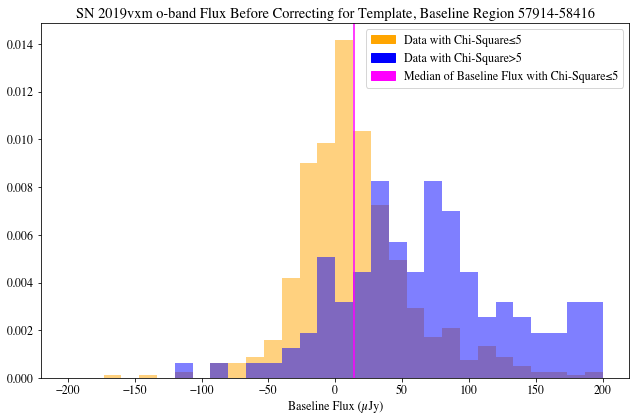

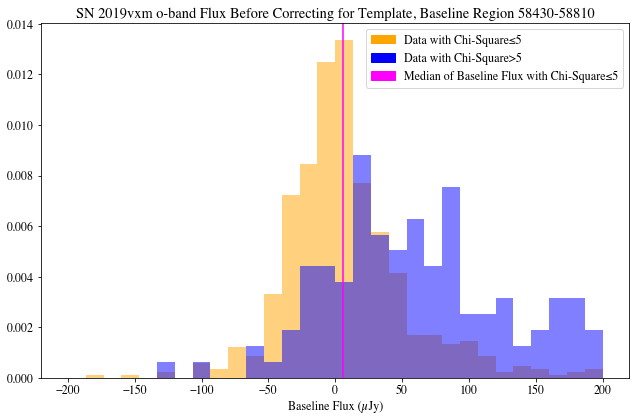

In [4]:
# get discovery date if needed, load in light curve, account for template changes, 
# and add uJy/duJy column

def get_tns_data(tnsname, api_key):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':api_key,'data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)

def get_discdate(tnsname, api_key):
	json_data = get_tns_data(tnsname, api_key)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	return disc_date

def get_regions():
	regions = {}
	regions['t0'] = lc_info['lc'].ix_inrange(colnames=['MJD'],uplim=tchange1)
	regions['t1'] = lc_info['lc'].ix_inrange(colnames=['MJD'],lowlim=tchange1,uplim=tchange2)
	regions['t2'] = lc_info['lc'].ix_inrange(colnames=['MJD'],lowlim=tchange2)
	regions['b_t0'] = AandB(regions['t0'],lc_info['baseline_i']) #lc_info['lc'].ix_inrange(colnames=['MJD'],uplim=tchange1,indices=lc_info['baseline_i'])
	regions['b_t1'] = AandB(regions['t1'],lc_info['baseline_i']) #lc_info['lc'].ix_inrange(colnames=['MJD'],lowlim=tchange1,uplim=tchange2,indices=lc_info['baseline_i'])
	regions['b_t2'] = AandB(regions['t2'],lc_info['baseline_i']) #lc_info['lc'].ix_inrange(colnames=['MJD'],lowlim=tchange2,indices=lc_info['baseline_i'])
	return regions

def plot_fdf(region_i,b_goodx2_i,b_badx2_i,median=None,xlim_lower=None,xlim_upper=None):
	plt.figure(figsize=(9,6))
	plt.title('SN %s %s-band Flux Before Correcting for Template, Baseline Region %d-%d' % (lc_info['tnsname'], lc_info['filter'], lc_info['lc'].t.loc[region_i[0],'MJD'], lc_info['lc'].t.loc[region_i[-1],'MJD']))
	plt.xlabel('Baseline Flux (µJy)')
	orange = mpatches.Patch(color='orange', label='Data with Chi-Square≤%d' % 5)
	blue = mpatches.Patch(color='blue', label='Data with Chi-Square>%d' % 5)
	if not(median is None): 
		plt.axvline(x=median,color='magenta')
		magenta = mpatches.Patch(color='magenta', label='Median of Baseline Flux with Chi-Square≤%d' % 5)
		plt.legend(handles=[orange, blue, magenta])
	else:
		plt.legend(handles=[orange,blue])
	if len(lc_info['baseline_i'])>0: 
		if xlim_lower is None: 
			xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy'])
		if xlim_upper is None:
			xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy'])
		plt.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy'], bins=30, color='orange', alpha=0.5, range=(xlim_lower,xlim_upper), density=True)
		plt.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy'], bins=30, color='blue', alpha=0.5, range=(xlim_lower,xlim_upper), density=True)
	else:
		plt.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy'], bins=30, color='orange', alpha=0.5, density=True)
		plt.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy'], bins=30, color='blue', alpha=0.5, density=True)
	plt.tight_layout()

def correct4template(xlim_lower=None, xlim_upper=None):
	b_goodx2_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=5,indices=lc_info['baseline_i'])
	b_badx2_i = AnotB(lc_info['baseline_i'],b_goodx2_i)

	regions = get_regions()
	for region_index in range(0,3):
		region_i = regions['b_t%d'%region_index]
		if len(region_i) > 0:
			print('Adjusting for template change in region b_t%d from %0.2f-%0.2f ' % (region_index, lc_info['lc'].t.loc[region_i[0],'MJD'], lc_info['lc'].t.loc[region_i[-1],'MJD']))
			print('# Baseline median before: ', np.median(lc_info['lc'].t.loc[region_i,'uJy']))

			if len(AandB(region_i,b_goodx2_i)) > 0:
				median = np.median(lc_info['lc'].t.loc[AandB(region_i,b_goodx2_i),'uJy'])
			else:
				median = np.median(lc_info['lc'].t.loc[region_i,'uJy'])
			
			plot_fdf(region_i,b_goodx2_i,b_badx2_i,median=median,xlim_lower=xlim_lower,xlim_upper=xlim_upper)
			
			print(f'# Subtracting median {median:0.1f} uJy of baseline flux with chi-square ≤ 5 from light curve flux due to potential flux in the template...')
			lc_info['lc'].t.loc[regions['t%d'%region_index],'uJy'] -= median

			print('# Baseline median now: ', np.median(lc_info['lc'].t.loc[region_i,'uJy']))
		else:
			print('No baseline region for region b_t%d, skipping... ' % region_index)

def drop_extra_columns(lc):
	dropcols=[]
	if 'Noffsetlc' in lc.columns: dropcols.append('Noffsetlc')
	if '__tmp_SN' in lc.columns: dropcols.append('__tmp_SN')
	for col in lc.columns:
		if re.search('^c\d_',col): 
			dropcols.append(col)
	if len(dropcols)>0: 
		print('Dropping extra columns: ',dropcols)
		lc.drop(columns=dropcols,inplace=True)

def load_lc(filename, xlim_lower=None, xlim_upper=None):
	lc_info['lc'] = pdastrostatsclass()
	try:
		print('Loading SN %s light curve at %s...' % (lc_info['tnsname'], filename))
		lc_info['lc'].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('Could not load light curve for SN %s at %s: %s' % (lc_info['tnsname'], filename, str(e)))
		sys.exit()
	
	lc_info['baseline_i'] = lc_info['lc'].ix_inrange(colnames=['MJD'],uplim=lc_info['discdate'],exclude_uplim=True)
	if len(lc_info['baseline_i'])<=0:
		print('Baseline length is 0--cannot find best chi-square cut! Exiting...')
		sys.exit()
	lc_info['afterdiscdate_i'] = AnotB(lc_info['lc'].getindices(), lc_info['baseline_i'])
	
	correct4template(xlim_lower=xlim_upper,xlim_upper=xlim_lower)
	drop_extra_columns(lc_info['lc'].t) # comment out this line if dropping columns is giving you unexpected trouble

	# add flux/dflux column
	if not('uJy/duJy' in lc_info['lc'].t.columns):
		print('Adding uJy/duJy column to light curve...')
		lc_info['lc'].t['uJy/duJy'] = lc_info['lc'].t['uJy']/lc_info['lc'].t['duJy']
		lc_info['lc'].t = lc_info['lc'].t.replace([np.inf, -np.inf], np.nan)

lc_info['tnsname'] = tnsname

if filter != 'o' and filter != 'c': 
	print('Filter must be "o" or "c"!')
	sys.exit()
lc_info['filter'] = filter

if discdate is None:
	print('Obtaining SN %s discovery date from TNS...' % lc_info['tnsname'])
	discdate = get_discdate(lc_info['tnsname'], api_key)
	print('Discovery date: ',discdate)
lc_info['discdate'] = discdate

load_lc(filename, xlim_lower=xlim_upper, xlim_upper=xlim_lower)

### 2: Plot the ATLAS light curve

In [ ]:
# Enter the scaling parameter for the SN plot's upper y limit 
# (ylim_upper = scale * 95th percentile flux):
scale = 2

# Optionally, manually enter the SN plot's x and y limits to override automatic scaling:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

In [ ]:
# plot the light curve

def get_xth_percentile_flux(percentile, indices):
    if len(indices)==0: 
        return None
    else:
        return np.percentile(lc_info['lc'].t.loc[indices, 'uJy'], percentile)

def plot_lc(ax, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('Flux (µJy)')
    ax.set_xlabel('MJD')
    ax.set_title('Supernova Flux')
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')

    # set x and y limits
    if xlim_lower is None: xlim_lower = lc_info['discdate']-70
    if xlim_upper is None: xlim_upper = lc_info['discdate']+500
    ax.set_xlim(xlim_lower, xlim_upper)
    if ylim_lower is None: ylim_lower = -200
    if ylim_upper is None: ylim_upper = scale*get_xth_percentile_flux(95, lc_info['afterdiscdate_i'])
    ax.set_ylim(ylim_lower,ylim_upper)

    ax.scatter(lc_info['lc'].t.loc[lc_info['baseline_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_i'],'uJy'], 
               s=35,color='b',marker='o',label='Baseline')

    ax.scatter(lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'MJD'], lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'uJy'],
               s=35,color='c',marker='o',label='During and after SN')
    
    fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

def plot_baseline(ax):
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('Flux (µJy)')
    ax.set_xlabel('MJD')
    ax.set_title('Baseline Flux')
    ax.axvline(x=tchange1,color='magenta')
    ax.axvline(x=tchange2,color='magenta')

    # set x and y limits
    xlim_lower = lc_info['lc'].t.loc[lc_info['baseline_i'][0],'MJD']-10
    xlim_upper = lc_info['lc'].t.loc[lc_info['baseline_i'][-1],'MJD']+10
    ax.set_xlim(xlim_lower,xlim_upper)
    ylim_lower = scale*get_xth_percentile_flux(5, lc_info['baseline_i'])
    ylim_upper = scale*get_xth_percentile_flux(95, lc_info['baseline_i'])
    ax.set_ylim(ylim_lower,ylim_upper)

    ax.scatter(lc_info['lc'].t.loc[lc_info['baseline_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_i'],'uJy'], 
               s=35,color='b',marker='o')

    ax.scatter(lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'MJD'], lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'uJy'],
               s=35,color='c',marker='o')


fig, axes = plt.subplots(nrows=1, ncols=2)
bl, lc = axes.flatten()
plt.suptitle('SN %s %s-band Light Curve' % (lc_info['tnsname'], lc_info['filter']), fontsize=15, y=1)
plot_baseline(bl)
plot_lc(lc, xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)
fig.tight_layout()

### 3: Plot the flux/dflux and chi-square distributions

The following two histograms display the flux/dflux and chi-square distributions of the target SN. Both histograms show probability density so as to ease comparison between the groups plotted within each histogram.

- The first histogram focuses on the baseline flux/dflux (µJy/dµJy) measurements, where we can expect the flux to equal 0. In orange, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value less than or equal to `x2bound`, which is currently set to 5 below; in blue, we plot flux/dflux (µJy/dµJy) measurements with a chi-square value greater than `x2bound`. 
- The second histogram focuses on the baseline chi-square measurements. In green, we plot chi-square measurements with an abs(µJy/dµJy) value less than or equal to `stnbound`, which is currently set to 3 below; in red, we plot chi-square measurements with an abs(µJy/dµJy) value greater than `stnbound`. 

Ideally, all measurements with a chi-square value less than or equal to `x2bound` should have an abs(µJy/dµJy) value less than or equal to `stnbound`, and measurements with a chi-square value greater than `x2bound` should have an abs(µJy/dµJy) value greater than `stnbound`. Our goal is to separate good measurements from bad measurements using a chi-square cut; in order for our cut to be effective, these histograms should hopefully showcase this relation between the target SN's flux/dflux and chi-square measurements.

In [ ]:
# Enter the bound that should separate a good chi-square measurement from a bad one:
x2bound = 5.0

# Enter the bound that should separate a good abs(flux/dflux) measurement from a bad one:
stnbound = 3.0

# Optionally, manually enter the histograms' x limits here:
# flux/dflux histogram x limits:
fdf_xlim_lower = -10
fdf_xlim_upper = 10 #300
# chi-square histogram x limits:
x2_xlim_lower = None
x2_xlim_upper = 20 #2000

In [ ]:
# plot flux/dflux and chi-square distribution histograms

def plot_hists(x2bound, stnbound, fdf_xlim_lower=None, fdf_xlim_upper=None, x2_xlim_lower=None, x2_xlim_upper=None):
    b_goodstn_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stnbound,uplim=stnbound,indices=lc_info['baseline_i'])
    b_badstn_i = AnotB(lc_info['baseline_i'],b_goodstn_i)
    b_goodx2_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=x2bound,indices=lc_info['baseline_i'])
    b_badx2_i = AnotB(lc_info['baseline_i'],b_goodx2_i)

    fig, axes = plt.subplots(nrows=1, ncols=2)
    stn, x2 = axes.flatten()
    plt.suptitle('SN %s %s-band (Baseline Only)' % (lc_info['tnsname'], lc_info['filter']), fontsize=15, y=1)

    stn.set_title('µJy/dµJy Distribution', fontsize=14)
    stn.set_xlabel('µJy/dµJy')
    orange = mpatches.Patch(color='orange', label='Data with Chi-Square < %0.2f' % x2bound)
    blue = mpatches.Patch(color='blue', label='Data with Chi-Square ≥ %0.2f' % x2bound)
    stn.legend(handles=[orange, blue]) #, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0: 
        if fdf_xlim_lower is None: 
            fdf_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        if fdf_xlim_upper is None: 
            fdf_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        stn.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
        stn.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
    else:
        stn.hist(lc_info['lc'].t.loc[b_goodx2_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, density=True)
        stn.hist(lc_info['lc'].t.loc[b_badx2_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, density=True)

    x2.set_title('Chi-Square Distribution', fontsize=14)
    x2.set_xlabel('Chi-Square')
    red = mpatches.Patch(color='green', label='Data with µJy/dµJy < %0.2f' % stnbound)
    green = mpatches.Patch(color='red', label='Data with µJy/dµJy ≥ %0.2f' % stnbound)
    x2.legend(handles=[red, green]) #, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0:
        if x2_xlim_lower is None: 
            x2_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        if x2_xlim_upper is None: 
            x2_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        x2.hist(lc_info['lc'].t.loc[b_goodstn_i, 'chi/N'], bins=30, color='green', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
        x2.hist(lc_info['lc'].t.loc[b_badstn_i, 'chi/N'], bins=30, color='red', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
    else:
        x2.hist(lc_info['lc'].t.loc[b_goodstn_i, 'chi/N'], bins=30, color='green', alpha=0.5, density=True)
        x2.hist(lc_info['lc'].t.loc[b_badstn_i, 'chi/N'], bins=30, color='red', alpha=0.5, density=True)
    
    fig.tight_layout()

plot_hists(x2bound, stnbound, fdf_xlim_lower=fdf_xlim_lower, fdf_xlim_upper=fdf_xlim_upper, x2_xlim_lower=x2_xlim_lower, x2_xlim_upper=x2_xlim_upper)

### 4: Calculate best chi-square cut based on contamination and loss

The following cells use two factors, <strong>contamination</strong> and <strong>loss</strong>, to attempt to calculate an optimal PSF chi-square cut for the target SN, with flux/dflux as the deciding factor of what constitutes a good measurement vs. a bad measurement. We aim to separate good measurements from bad using the calculated chi-square cut by removing as much contamination as possible with the smallest loss possible. Since we can assume that the expected value of the baseline flux is 0, we look only at the baseline measurements before the SN occurs in order to determine the best chi-square cut for the SN itself.

First, we decide what will determine a good measurement vs. a bad measurement using a factor outside of the chi-square values. Our chosen factor is the <strong>absolute value of flux (µJy) divided by dflux (dµJy)</strong>. The recommended boundary is a value of 3, such that any measurements with a value of abs(µJy/dµJy) less than or equal to 3 are regarded as "good" measurements, and any measurements with a value of abs(µJy/dµJy) greater than 3 are regarded as "bad" measurements. You can set this boundary to a different number by changing the value of `stn_cut` below.

Next, we set the upper and lower bounds of our final chi-square cut. We start at a low value of 3 (which can be changed by setting the value of `cut_start` below) and end at 50 (this value is inclusive and can be changed by setting the value of `cut_stop` below) with a step size of 1 (`cut_step` below). <strong>For chi-square cuts falling on or between `cut_start` and `cut_stop` in increments of `cut_step`, we can begin to calculate contamination and loss percentages.</strong>

We define contamination to be the number of bad kept measurements over the total number of kept measurements for that chi-square cut (<strong>contamination = Nbad,kept/Nkept</strong>). For our final chi-square cut, we can also set a limit on what maximum percent contamination we want to have--the recommended value is <strong>10%</strong> but can be changed by setting the value of `contam_lim` below.

We define loss to be the number of good cut measurements over the total number of good measurements for that chi-square cut (<strong>loss = Ngood,cut/Ngood</strong>). For our final chi-square cut, we can also set a limit on what maximum percent loss we want to have--the recommended value is <strong>10%</strong> but can be changed by setting the value of `loss_lim` below.

Finally, we define which limit (`contam_lim` or `loss_lim`) to prioritize in the event that an optimal chi-square cut fitting both limits is not found. The default prioritized limit is `loss_lim` but can be changed by setting the value of `lim_to_prioritize` below.

In [ ]:
# Enter the abs(uJy/duJy) boundary that will determine a "good" measurement vs. "bad" measurement:
stn_cut = 3

# Enter the bounds for the final chi-square cut (minimum cut, maximum cut, and step):
cut_start = 3 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# Enter the contamination limit (contamination = Nbad,kept/Nkept must be <= contam_lim% 
# for the final chi-square cut):
contam_lim = 15.0

# Enter the loss limit (loss = Ngood,cut/Ngood must be >= loss_lim%
# for the final chi-square cut):
loss_lim = 10.0

# Enter the limit to prioritize (must be 'loss_lim' or 'contam_lim') in the event that
# one or both limits are not met:
lim_to_prioritize = 'loss_lim'

The following section describes in detail how we determine the final chi-square cut using the given contamination and loss limits.

For each given limit (contamination and loss), we calculate a range of valid cuts whose contamination/loss percentage is less than that limit and then choose a single cut within that valid range. Then, we pass through a decision tree to determine which of the two suggested cuts to use using a variety of factors (including the user's selected `lim_to_prioritize`).

When choosing the loss cut according to the loss percentage limit `loss_lim`:
- <strong>If all loss percentages are below the limit</strong> `loss_lim`, all cuts falling on or between `cut_start` and `cut_stop` are valid.
- <strong>If all loss percentages are above the limit</strong> `loss_lim`, a cut with the required loss percentage is not possible; therefore, any cuts with the smallest percentage of loss are valid.
- <strong>Otherwise</strong>, the valid range of cuts includes any cuts with the loss percentage less than or equal to the limit `loss_lim`.
- The chosen cut for this limit is the <strong>minimum cut</strong> within the stated valid range of cuts.

When choosing the loss cut according to the contamination percentage limit `contam_lim`:
- <strong>If all contamination percentages are below the limit</strong> `contam_lim`, all cuts falling on or between `cut_start` and `cut_stop` are valid.
- <strong>If all contamination percentages are above the limit</strong> `contam_lim`, a cut with the required contamination percentage is not possible; therefore, any cuts with the smallest percentage of contamination are valid.
- <strong>Otherwise</strong>, the valid range of cuts includes any cuts with the contamination percentage less than or equal to the limit `contam_lim`.
- The chosen cut for this limit is the <strong>maximum cut</strong> within the stated valid range of cuts.

After we have calculated two suggested cuts based on the loss and contamination percentage limits, we follow the decision tree in order to suggest a final cut:
- If both loss and contamination cut percentages were chosen from a range that spanned from `cut_start` to `cut_stop`, we set the final cut to `cut_start`.
- If one cut's percentage was chosen from a range that spanned from `cut_start` to `cut_stop` and the other cut's percentage was not, we set the final cut to the latter cut.
- If both percentages were chosen from ranges that fell above their respective limits, we suggest reselecting either or both limits.
- Otherwise, we take into account the user's prioritized limit `lim_to_prioritize`:
    - If the loss cut is greater than the contamination cut, we set the final cut to whichever cut is associated with `lim_to_prioritize`.
    - Otherwise, if `lim_to_prioritize` is set to `contam_lim`, we set the final cut to the loss cut, and if `lim_to_prioritize` is set to `loss_lim`, we set the final cut to the contamination cut.

In [ ]:
# calculate the suggested best chi-square cut using contamination and loss

def plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut):
    fig = plt.figure()
    plt.title('SN %s %s-band Dynamic PSF Chi-Square Cut (Baseline Only)' % (lc_info['tnsname'],lc_info['filter']))

    plt.axhline(linewidth=1,color='k')
    plt.xlabel('PSF Chi-Square Cut')
    plt.ylabel('% of Baseline Measurements')

    plt.axhline(loss_lim,linewidth=1,color='r',linestyle='--',label='Loss Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Ploss'],ms=5,color='r',marker='o',label='Loss')
    plt.axvline(x=loss_lim_cut,color='r',label='Loss Cut')
    plt.axvspan(loss_lim_cut, cut_stop, alpha=0.2, color='r')

    plt.axhline(contam_lim,linewidth=1,color='g',linestyle='--',label='Contamination Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Pcontamination'],ms=5,color='g',marker='o',label='Contamination')
    plt.axvline(x=contam_lim_cut,color='g',label='Contamination Cut')
    plt.axvspan(cut_start, contam_lim_cut, alpha=0.2, color='g')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.tight_layout()
    #fig.savefig('000001.png',bbox_inches="tight",dpi=200)

def choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case):
    # case 1 and 1: final_cut = 3
    # case 1 and 2: take limit of case 2
    # case 1 and 3: take limit of case 3
    # case 2 and 2: print lims don't work
    # case 2 and 3: choose_btwn_lim_cuts
    # case 3 and 3: choose_btwn_lim_cuts

    case1 = loss_case == 'below lim' or contam_case == 'below lim'
    case2 = loss_case == 'above lim' or contam_case == 'above lim'
    case3 = loss_case == 'crosses lim' or contam_case == 'crosses lim'

    final_cut = None
    if case1 and not case2 and not case3: # 1 and 1
        print('Valid chi-square cut range from %0.2f to %0.2f! Setting to 3...' % (loss_lim_cut, contam_lim_cut))
        final_cut = cut_start
    elif case1: # 1
        if case2: # and 2
            if loss_case == 'above lim':
                print('WARNING: contam_lim_cut <= %0.2f falls below limit %0.2f%%, but loss_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('WARNING: loss_lim_cut <= %0.2f falls below limit %0.2f%%, but contam_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
        else: # and 3
            if loss_case == 'crosses lim':
                print('Contam_lim_cut <= %0.2f falls below limit %0.2f%% and loss_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Loss_lim_cut <= %0.2f falls below limit %0.2f%% and contam_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
    elif case2 and not case3: # 2 and 2
        print('ERROR: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f both fall above limits %0.2f%% and %0.2f%%! Try setting less strict limits. Setting final cut to nan.' % (loss_lim_cut, contam_lim_cut, loss_lim, contam_lim))
        final_cut = np.nan
    else: # 2 and 3 or 3 and 3
        if loss_lim_cut > contam_lim_cut:
            print('WARNING: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f do not overlap! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f...' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
        else:
            print('Valid chi-square cut range from %0.2f to %0.2f! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
    return final_cut

def get_lim_cuts_data(cut, add2col, indices=None):
    if indices is None:
        indices = lc_info['baseline_i']

    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
    b_cut_i = AnotB(indices, b_kept_i)

    lc_info['%sNgood' % add2col] = len(b_good_i)
    lc_info['%sNbad' % add2col] = len(b_bad_i)
    lc_info['%sNkept' % add2col] = len(b_kept_i)
    lc_info['%sNcut' % add2col] = len(b_cut_i)
    lc_info['%sNgood,kept' % add2col] = len(AandB(b_good_i,b_kept_i))
    lc_info['%sNgood,cut' % add2col] = len(AandB(b_good_i,b_cut_i))
    lc_info['%sNbad,kept' % add2col] = len(AandB(b_bad_i,b_kept_i))
    lc_info['%sNbad,cut' % add2col] = len(AandB(b_bad_i,b_cut_i))
    lc_info['%sPgood,kept' % add2col] = 100*len(AandB(b_good_i,b_kept_i))/len(indices)
    lc_info['%sPgood,cut' % add2col] = 100*len(AandB(b_good_i,b_cut_i))/len(indices)
    lc_info['%sPbad,kept' % add2col] = 100*len(AandB(b_bad_i,b_kept_i))/len(indices)
    lc_info['%sPbad,cut' % add2col] = 100*len(AandB(b_bad_i,b_cut_i))/len(indices)
    lc_info['%sNgood,kept/Ngood' % add2col] = 100*len(AandB(b_good_i,b_kept_i))/len(b_good_i)
    lc_info['%sPloss' % add2col] = 100*len(AandB(b_good_i,b_cut_i))/len(b_good_i)
    lc_info['%sPcontamination' % add2col] = 100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i)

def get_lim_cuts(lim_cuts): 
    contam_lim_cut = None
    loss_lim_cut = None
    contam_case = None
    loss_case = None

    sortby_loss = lim_cuts.t.iloc[(lim_cuts.t['Ploss']).argsort()].reset_index()
    min_loss = sortby_loss.loc[0,'Ploss']
    max_loss = sortby_loss.loc[len(sortby_loss)-1,'Ploss']
    # if all loss below lim, loss_lim_cut is min cut
    if min_loss < loss_lim and max_loss < loss_lim:
        loss_case = 'below lim'
        loss_lim_cut = lim_cuts.t.loc[0,'PSF Chi-Square Cut']
    else:
        # else if all loss above lim, loss_lim_cut is min cut with min% loss
        if min_loss > loss_lim and max_loss > loss_lim:
            loss_case = 'above lim'
            a = np.where(lim_cuts.t['Ploss'] == min_loss)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            loss_lim_cut = c.loc[0,'PSF Chi-Square Cut']
        # else if loss crosses lim at some point, loss_lim_cut is min cut with max% loss <= loss_lim
        else:
            loss_case = 'crosses lim'
            valid_cuts = sortby_loss[sortby_loss['Ploss'] <= loss_lim]
            a = np.where(lim_cuts.t['Ploss'] == valid_cuts.loc[len(valid_cuts)-1,'Ploss'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of loss1 and loss2 (two points on either side of lim)
            loss1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[0,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[loss1_i,'Ploss'] == loss_lim:
                loss_lim_cut = lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut']
            else:
                loss2_i = loss1_i - 1
                x = np.array([lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[loss2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[loss1_i,'Pcontamination'], lim_cuts.t.loc[loss2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[loss1_i,'Ploss'], lim_cuts.t.loc[loss2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                loss_lim_cut = (loss_lim-loss_line[1])/loss_line[0]

    sortby_contam = lim_cuts.t.iloc[(lim_cuts.t['Pcontamination']).argsort()].reset_index()
    min_contam = sortby_contam.loc[0,'Pcontamination']
    max_contam = sortby_contam.loc[len(sortby_contam)-1,'Pcontamination']
    # if all contam below lim, contam_lim_cut is max cut
    if min_contam < contam_lim and max_contam < contam_lim:
        contam_case = 'below lim'
        contam_lim_cut = lim_cuts.t.loc[len(lim_cuts.t)-1,'PSF Chi-Square Cut']
    else:
        # else if all contam above lim, contam_lim_cut is max cut with min% contam
        if min_contam > contam_lim and max_contam > contam_lim:
            contam_case = 'above lim'
            a = np.where(lim_cuts.t['Pcontamination'] == min_contam)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            contam_lim_cut = c.loc[len(c)-1,'PSF Chi-Square Cut']
        # else if contam crosses lim at some point, contam_lim_cut is max cut with max% contam <= contam_lim
        else:
            contam_case = 'crosses lim'
            valid_cuts = sortby_contam[sortby_contam['Pcontamination'] <= contam_lim]
            a = np.where(lim_cuts.t['Pcontamination'] == valid_cuts.loc[len(valid_cuts)-1,'Pcontamination'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of contam1 and contam2 (two points on either side of lim)
            contam1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[len(c)-1,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[contam1_i,'Pcontamination'] == contam_lim:
                contam_lim_cut = lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut']
            else:
                contam2_i = contam1_i + 1
                x = np.array([lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[contam2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[contam1_i,'Pcontamination'], lim_cuts.t.loc[contam2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[contam1_i,'Ploss'], lim_cuts.t.loc[contam2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                contam_lim_cut = (contam_lim-contam_line[1])/contam_line[0]

    get_lim_cuts_data(loss_lim_cut, 'loss_lim_cut_')
    get_lim_cuts_data(contam_lim_cut, 'contam_lim_cut_')

    return contam_lim_cut, loss_lim_cut, contam_case, loss_case

def get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step, indices=None):
    print('abs(uJy/duJy) cut at %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (stn_cut,cut_start,cut_stop,cut_step))

    if indices is None: 
        indices = lc_info['baseline_i']

    lim_cuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                          'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                          'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
    
    # static cut at x2 = 50
    x2cut_50 = np.where(lc_info['lc'].t['chi/N'] < 50)[0]
    print('Static chi square cut at 50: %0.2f%% cut for baseline' % (100*len(AnotB(indices,x2cut_50))/len(indices)))

    # good baseline measurement indices
    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    # for different x2 cuts decreasing from 50
    for cut in range(cut_start,cut_stop+1,cut_step):
        # kept baseline measurement indices
        b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
        b_cut_i = AnotB(indices, b_kept_i)

        df = pd.DataFrame([[cut, len(indices), # N
                            len(b_good_i), # Ngood
                            len(b_bad_i), # Nbad
                            len(b_kept_i), # Nkept
                            len(b_cut_i), # Ncut
                            len(AandB(b_good_i,b_kept_i)), # Ngood,kept
                            len(AandB(b_good_i,b_cut_i)), # Ngood,cut
                            len(AandB(b_bad_i,b_kept_i)), # Nbad,kept
                            len(AandB(b_bad_i,b_cut_i)), # Nbad,cut
                            100*len(AandB(b_good_i,b_kept_i))/len(indices), # Ngood,kept/Nbaseline
                            100*len(AandB(b_good_i,b_cut_i))/len(indices), # Ngood,cut/Nbaseline 
                            100*len(AandB(b_bad_i,b_kept_i))/len(indices), # Nbad,kept/Nbaseline
                            100*len(AandB(b_bad_i,b_cut_i))/len(indices), # Nbad,cut/Nbaseline
                            100*len(AandB(b_good_i,b_kept_i))/len(b_good_i), # Ngood,kept/Ngood
                            100*len(AandB(b_good_i,b_cut_i))/len(b_good_i), # Ngood,cut/Ngood = Loss
                            100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i), # Nbad,kept/Nkept = Contamination
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,cut 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,cut 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_cut_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,cut 10<stn 
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,kept 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,kept 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_kept_i), lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,kept 10<stn 
                            ]], columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                         'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                         'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
        lim_cuts.t = pd.concat([lim_cuts.t,df],ignore_index=True)
    return lim_cuts

if lim_to_prioritize != 'loss_lim' and lim_to_prioritize != 'contam_lim':
    print("ERROR: lim_to_prioritize must be 'loss_lim' or 'contam_lim'!")
    sys.exit()
print('Contamination limit: %0.2f%%\nLoss limit: %0.2f%%' % (contam_lim,loss_lim))

lim_cuts = get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step)
#print(lim_cuts.t.to_string())
contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lim_cuts)
lc_info['contam_case'] = contam_case
lc_info['loss_case'] = loss_case
lc_info['contam_lim_cut'] = contam_lim_cut
lc_info['loss_lim_cut'] = loss_lim_cut

print('\nContamination cut according to given contam_limit, with %0.2f%% contamination and %0.2f%% loss: %0.2f' % (lc_info['contam_lim_cut_Pcontamination'], lc_info['contam_lim_cut_Ploss'], contam_lim_cut))
if lc_info['contam_case'] == 'above lim':
    print('WARNING: Contamination cut not possible with contamination <= contam_lim %0.1f!' % contam_lim)
print('Loss cut according to given loss_limit, with %0.2f%% contamination and %0.2f%% loss: %0.2f' % (lc_info['loss_lim_cut_Pcontamination'], lc_info['loss_lim_cut_Ploss'], loss_lim_cut))
if lc_info['loss_case'] == 'above lim':
    print('WARNING: Loss cut not possible with loss <= loss_lim %0.2f!' % loss_lim)

final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
lc_info['final_cut'] = final_cut
        
if np.isnan(final_cut):
    print('\nERROR: Final suggested chi-square cut could not be determined. We suggest rethinking your contamination and loss limits.')
    lc_info['Pcontamination'] = np.nan
    lc_info['Ploss'] = np.nan
else:
    if final_cut==contam_lim_cut:
        lc_info['Pcontamination'] = lc_info['contam_lim_cut_Pcontamination']
        lc_info['Ploss'] = lc_info['contam_lim_cut_Ploss']
    else:
        lc_info['Pcontamination'] = lc_info['loss_lim_cut_Pcontamination']
        lc_info['Ploss'] = lc_info['loss_lim_cut_Ploss']
    print('\nFinal suggested chi-square cut is %0.2f, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info['Pcontamination'], lc_info['Ploss']))
    if (lc_info['Pcontamination'] > contam_lim):
        print('WARNING: Final cut\'s contamination %0.2f%% exceeds contam_lim %0.2f%%!' % (lc_info['Pcontamination'],contam_lim))
    if (lc_info['Ploss'] > loss_lim):
        print('WARNING: Final cut\'s loss exceeds %0.2f%% loss_lim %0.2f%%!' % (lc_info['Ploss'],loss_lim))

plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut)

In [ ]:
# confirm the final chi-square cut; if not, ask for user override

answer = input('Accept final chi-square cut of %0.2f (y/n):' % float(lc_info['final_cut']))
if answer != 'y':
    final_cut_override = float(input('Overriding final chi-square cut; enter manual cut: '))

    b_good_i = lc_info['lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=lc_info['baseline_i'])
    b_bad_i = AnotB(lc_info['baseline_i'], b_good_i)
    b_kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=final_cut_override,indices=lc_info['baseline_i'])
    b_cut_i = AnotB(lc_info['baseline_i'], b_kept_i)
    lc_info['Ploss'] = 100*len(AandB(b_good_i,b_cut_i))/len(b_good_i)
    lc_info['Pcontamination'] = 100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i)
    lc_info['final_cut'] = final_cut_override

    print('Overridden: final cut is now %0.2f, with contamination %0.2f%% and loss %0.2f%%' % (lc_info['final_cut'],lc_info['Pcontamination'],lc_info['Ploss']))

### 5: Plot the ATLAS light curve with the chi-square cut

In [ ]:
def plot_cut_lc(cut, colname, plot_cut=True, ylim_lower=None, ylim_upper=None):
    kept_i = lc_info['lc'].ix_inrange(colnames=[colname],uplim=cut)
    cut_i = AnotB(lc_info['lc'].getindices(), kept_i)

    fig = plt.figure()
    plt.axhline(linewidth=1,color='k')
    plt.ylabel('Flux (µJy)')
    plt.xlabel('MJD')
    if plot_cut:
        plt.title('SN %s %s-band, chi-square cut of %0.2f' % (lc_info['tnsname'], lc_info['filter'], cut))
    else:
        plt.title('SN %s %s-band, kept measurements, chi-square cut of %0.2f' % (lc_info['tnsname'], lc_info['filter'], cut))
    plt.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    plt.axvline(x=tchange2,color='magenta')

    if ylim_lower is None: 
        ylim_lower = -200
    if ylim_upper is None: 
        if plot_cut:
            ylim_upper = scale*get_xth_percentile_flux(95, lc_info['afterdiscdate_i'])
        else:
            ylim_upper = scale*get_xth_percentile_flux(95, AandB(lc_info['afterdiscdate_i'],kept_i))
    plt.ylim(ylim_lower,ylim_upper)

    plt.scatter(lc_info['lc'].t.loc[AandB(lc_info['baseline_i'],kept_i),'MJD'], lc_info['lc'].t.loc[AandB(lc_info['baseline_i'],kept_i),'uJy'], 
               s=35,color='b',marker='o',label='Kept Baseline Flux')
    if plot_cut:
        plt.scatter(lc_info['lc'].t.loc[AandB(lc_info['baseline_i'],cut_i),'MJD'], lc_info['lc'].t.loc[AandB(lc_info['baseline_i'],cut_i),'uJy'], 
                    s=35,color='b',marker='o',facecolors='white',label='Cut Baseline Flux')

    plt.scatter(lc_info['lc'].t.loc[AandB(lc_info['afterdiscdate_i'],kept_i),'MJD'], lc_info['lc'].t.loc[AandB(lc_info['afterdiscdate_i'],kept_i),'uJy'],
               s=35,color='c',marker='o',label='Kept During and After SN Flux')
    if plot_cut:
        plt.scatter(lc_info['lc'].t.loc[AandB(lc_info['afterdiscdate_i'],cut_i),'MJD'], lc_info['lc'].t.loc[AandB(lc_info['afterdiscdate_i'],cut_i),'uJy'],
                    s=35,color='c',marker='o',facecolors='white',label='Cut During and After SN Flux')
    
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plot_cut_lc(lc_info['final_cut'], 'chi/N', plot_cut=True)
plot_cut_lc(lc_info['final_cut'], 'chi/N', plot_cut=False)

### 6: Restart the 'Mask' column and update with the chi-square cut flag

In [ ]:
def update_mask_col(lc, flag, indices):
    if len(indices) > 1:
        flag_arr = np.full(lc.loc[indices,'Mask'].shape, flag)
        lc.loc[indices,'Mask'] = np.bitwise_or(lc.loc[indices,'Mask'], flag_arr)
    elif len(indices) == 1:
        lc.loc[indices[0],'Mask'] = int(lc.loc[indices[0],'Mask']) | flag
    else:
        print('WARNING: must pass at least 1 index to update_mask_col()! No indices masked...')

# remove old mask column
if 'Mask' in lc_info['lc'].t.columns: 
    lc_info['lc'].t.drop(columns=['Mask'],inplace=True)

# create new mask column and update it with final chi-square cut
lc_info['lc'].t['Mask'] = 0
kept_i = lc_info['lc'].ix_inrange(colnames=['chi/N'],uplim=lc_info['final_cut'])
cut_i = AnotB(lc_info['lc'].getindices(), kept_i)
update_mask_col(lc_info['lc'].t, 0x1, cut_i)

## Part 2: Averaging

[FIX/EDIT DESCRIPTION HERE]

Can we identify and cut out bad days by taking a 3σ-clipped average of each day?

For each day, we calculate the 3σ-clipped average of any SN measurements falling within that day. Because the ATLAS survey takes ~4 exposures every 2 days, we average together ~4 measurements per epoch. However, out of these 4 exposures, only measurements not cut in the previous methods are averaged in the 3σ cut.

Then we cut any measurements in the SN light curve for the given epoch for which statistics fulfill any of the following criteria: 
- A returned chi-square > 4.0
- Number of measurements averaged < 2
- Number of measurements clipped > 1

Still need to improve cutting at peak (some important epochs were cut, maybe due to fast rise, etc.).

In [ ]:
# Enter the MJD bin size:
mjdbinsize = 1

# Should MJD bins with no measurements be translated as NaN (True) 
# or removed from the averaged light curve (False)?
keep_empty_bins = False

# Enter the magnitudes' sigma limit (magnitudes are limits if dmagnitude is NaN):
flux2mag_sigma_limit = 3

# Enter the bound for a bin's maximum number of clipped measurements
# (if Nclip > Nclip_max, flag day):
Nclip_max = 1

# Enter the bound for a bin's minimum number of good measurements
# (if Ngood < Ngood_min, flag day):
Ngood_min = 2

# Enter the bound for a bin's maximum chi-square (if x2 > x2_max, flag day):
x2_max = 4.0

In [ ]:
def average_lc(Nclip_max, Ngood_min, x2_max, flag_badday, flag_ixclip, flag_smallnum, mjdbinsize=1, flux2mag_sigma_limit=3.0, keep_empty_bins=True):
    mjd = int(np.amin(lc_info['lc'].t['MJD']))
    mjd_max = int(np.amax(lc_info['lc'].t['MJD']))+1

    good_i = lc_info['lc'].ix_unmasked('Mask', maskval=0x1)

    while mjd <= mjd_max:
        range_i = lc_info['lc'].ix_inrange(colnames=['MJD'], lowlim=mjd, uplim=mjd+mjdbinsize, exclude_uplim=True)
        range_good_i = AandB(range_i,good_i)

        # add new row to avglc if keep_empty_bins or any measurements present
        if keep_empty_bins or len(range_i) >= 1:
            new_row = {'MJDbin':mjd+0.5*mjdbinsize, 'Nclip':0, 'Ngood':0, 'Nexcluded':len(range_i)-len(range_good_i), 'Mask':0}
            avglc_index = lc_info['avglc'].newrow(new_row)
        
        # if no measurements present, flag or skip over day
        if len(range_i) < 1:
            if keep_empty_bins:
                update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])
            mjd += mjdbinsize
            continue
        
        # if no good measurements, average values anyway and flag
        if len(range_good_i) < 1:
            # average flux
            lc_info['lc'].calcaverage_sigmacutloop('uJy', noisecol='duJy', indices=range_i, Nsigma=3.0, median_firstiteration=True)
            fluxstatparams = deepcopy(lc_info['lc'].statparams)

            # average mjd
            # SHOULD NOISECOL HERE BE DUJY OR NONE??
            lc_info['lc'].calcaverage_sigmacutloop('MJD', noisecol='duJy', indices=fluxstatparams['ix_good'], Nsigma=0, median_firstiteration=False)
            avg_mjd = lc_info['lc'].statparams['mean']

            # add row and flag
            lc_info['avglc'].add2row(avglc_index, {'MJD':avg_mjd, 
                                                   'uJy':fluxstatparams['mean'], 
                                                   'duJy':fluxstatparams['mean_err'], 
                                                   'stdev':fluxstatparams['stdev'],
                                                   'x2':fluxstatparams['X2norm'],
                                                   'Nclip':fluxstatparams['Nclip'],
                                                   'Ngood':fluxstatparams['Ngood'],
                                                   'Mask':0})
            update_mask_col(lc_info['lc'].t, flag_badday, range_i)
            update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])

            mjd += mjdbinsize
            continue
        
        # average good measurements
        lc_info['lc'].calcaverage_sigmacutloop('uJy', noisecol='duJy', indices=range_good_i, Nsigma=3.0, median_firstiteration=True)
        fluxstatparams = deepcopy(lc_info['lc'].statparams)

        if fluxstatparams['mean'] is None or len(fluxstatparams['ix_good']) < 1:
            update_mask_col(lc_info['lc'].t, flag_badday, range_i)
            update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])
            mjd += mjdbinsize
            continue

        # average mjd
        # SHOULD NOISECOL HERE BE DUJY OR NONE??
        lc_info['lc'].calcaverage_sigmacutloop('MJD', noisecol='duJy', indices=fluxstatparams['ix_good'], Nsigma=0, median_firstiteration=False)
        avg_mjd = lc_info['lc'].statparams['mean']

        # add row
        lc_info['avglc'].add2row(avglc_index, {'MJD':avg_mjd, 
                                                   'uJy':fluxstatparams['mean'], 
                                                   'duJy':fluxstatparams['mean_err'], 
                                                   'stdev':fluxstatparams['stdev'],
                                                   'x2':fluxstatparams['X2norm'],
                                                   'Nclip':fluxstatparams['Nclip'],
                                                   'Ngood':fluxstatparams['Ngood'],
                                                   'Mask':0})
        
        # flag clipped measurements in lc
        if len(fluxstatparams['ix_clip']) > 0:
            update_mask_col(lc_info['lc'].t, flag_ixclip, fluxstatparams['ix_clip'])
        
        # if small number within this bin, flag measurements
        if len(range_good_i) < 3:
            update_mask_col(lc_info['lc'].t, flag_smallnum, range_good_i) # CHANGE TO RANGE_I??
            update_mask_col(lc_info['avglc'].t, flag_smallnum, [avglc_index])
        # else check sigmacut bounds and flag
        else:
            is_bad = False
            if fluxstatparams['Ngood'] < Ngood_min:
                is_bad = True
            if fluxstatparams['Nclip'] > Nclip_max:
                is_bad = True
            if not(fluxstatparams['X2norm'] is None) and fluxstatparams['X2norm'] > x2_max:
                is_bad = True
            if is_bad:
                update_mask_col(lc_info['lc'].t, flag_badday, range_i)
                update_mask_col(lc_info['avglc'].t, flag_badday, [avglc_index])

        mjd += mjdbinsize
    
    # convert flux to magnitude and dflux to dmagnitude
    lc_info['avglc'].flux2mag('uJy','duJy','m','dm', zpt=23.9, upperlim_Nsigma=flux2mag_sigma_limit)

    print('Success')

    drop_extra_columns(lc_info['avglc'].t)

    for col in ['Nclip','Ngood','Nexcluded','Mask']: 
        lc_info['avglc'].t[col] = lc_info['avglc'].t[col].astype(np.int32)

if len(lc_info['lc'].t) < 1:
    print('ERROR: No data in lc so cannot average; exiting... ')
    sys.exit()

print('Averaging light curve with the following criteria: Nclip_max = %d, Ngood_min = %d, x2_max = %0.2f... ' % (Nclip_max, Ngood_min, x2_max))
lc_info['avglc'] = pdastrostatsclass(columns=['MJD','MJDbin','uJy','duJy','stdev','x2','Nclip','Ngood','Nexcluded','Mask'],hexcols=['Mask'])
average_lc(Nclip_max, Ngood_min, x2_max, 0x800000, 0x1000, 0x2000, keep_empty_bins=keep_empty_bins)

### 7: Save the light curve with the new 'Mask' column

In [ ]:
# Save the light curve with the new 'Mask' column?
save_lc = True

# Override the old light curve file?
override_old_lc = False

# If not overriding old light curve file, enter new filename:
filename_new = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/NEW_2019vxm_i000.o.1.00days.lc.txt'

In [ ]:
# save light curve
if save_lc:
    print('Saving light curve with updated mask column...')
    if override_old_lc:
        print('Overriding old light curve file at %s... ' % filename)
        lc_info['avglc'].write(filename,overwrite=True)
    else:
        print('Writing new file at %s... ' % filename_new)
        lc_info['avglc'].write(filename_new,overwrite=False)